# Running FEISTY with time-series forcing from CESM

Kristen produced a 1 degree companion run to our high-res run on frontera, and then converted output to time series.
This notebook doesn't really need to be a notebook, I'm hoping it can be converted to a script instead.
All the parameter settings are handled in the first (non-`import`) cell, where we read in `feisty-config.TL319_g17.4p2z.001.yml`.
This was run on a casper login node with 4 GB of memory, but all data is kept distributed on the dask cluster.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import dask
import matplotlib.pyplot as plt
import nc_time_axis  # needed for time series plot for some reason
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client
from dask_jobqueue import PBSCluster
import zarr
import zarr.storage

import feisty

## Configure run

The FEISTY command `config_and_run_from_yaml()` needs a dictionary pointing to forcing streams and initial conditions.
We provide a few `YAML` files containing acceptable configurations.
There are also several parameters controlling how the run is set up.

In [3]:
# Read settings from YAML
feisty_config_file = 'feisty-config.BHIST003-4p2z.yml'
with open(feisty_config_file) as f:
    feisty_config = yaml.safe_load(f)

outdir = os.path.join(
    os.path.sep, 'glade', 'derecho', 'scratch', os.environ['USER'],
    f"feisty_output_{os.environ.get('CONDA_DEFAULT_ENV', 'unknown')}"
)

## Set up Dask cluster

Since the data in `ds` is chunked in (`nlat`, `nlon`), we use a `dask` cluster to configure the parallelization

In [4]:
mem = 20  # GB
dask.config.set({'distributed.dashboard.link': 'proxy/{port}/status'})
# dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
# dask.config.set({"distributed.comm.timeouts.connect": "180s"})
cluster = PBSCluster(
    memory=f'{mem} GB',
    processes=1,
    cores=1,
    queue='casper',
    walltime='1:00:00',
    resource_spec=f'select=1:ncpus=1:mem={mem}GB',
    log_directory='./dask-logs',
)

cluster.scale(feisty_config['num_workers'])
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: proxy/8787/status,
Dashboard: proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.115:46473,Workers: 0
Dashboard: proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%%time

client.wait_for_workers(feisty_config['num_workers'])

CPU times: user 1.37 s, sys: 189 ms, total: 1.56 s
Wall time: 35.4 s


## Run the model

In [6]:
%%time

start_year = 1999
end_year = 2001
nyears = end_year - start_year + 1
output_suffix = 'zarr'

feisty_config['start_date'] = f'{start_year}-01-01'
feisty_config['end_date'] = f'{end_year}-12-31'

chunks = feisty_config.get("chunks") if feisty_config["num_workers"] > 1 else None
POP_units = feisty_config["forcing"].get("POP_units", False)
debug_outdir = f"/glade/derecho/scratch/{os.environ['USER']}/feisty_forcing/full_forcing_dataset.zarr"

feisty_forcing = feisty.utils.get_forcing_from_config(feisty_config)
ds_forcing = feisty.utils.generate_forcing_ds_from_config(feisty_forcing, chunks, POP_units, debug_outdir=debug_outdir)


for year in range(start_year, start_year + nyears):
    print(f'Configuring FEISTY for {year}...')

    # Start and End dates
    feisty_config['start_date'] = f'{year}-01-01'
    feisty_config['end_date'] = f'{year}-12-31'

    # Initialize from restart (unless this is first year)
    previous_restart = f'companion.{year-1}-12-31.{output_suffix}'
    if os.path.exists(os.path.join(outdir, 'rest', previous_restart)):
        print(f'Restarting from {previous_restart}')
        feisty_config['initial_conditions'] = {
            'root_dir': os.path.join(outdir, 'rest'),
            'ic_file': previous_restart,
        }

    # Set up history and restart files for output
    feisty_config['output']['hist_dir'] = os.path.join(outdir, 'hist')
    feisty_config['output']['hist_file'] = f'companion.{year}.{output_suffix}'
    feisty_config['output']['rest_dir'] = os.path.join(outdir, 'rest')
    feisty_config['output']['rest_file'] = f'companion.{year}-12-31.{output_suffix}'

    # map_blocks lets us run in parallel over our dask cluster
    print(f'Running FEISTY for year {year}...')
    ds_out = feisty.config_and_run_from_yaml(feisty_config, ds=ds_forcing)

# ds_out = xr.concat(ds_list, dim='time')
ds_out["biomass"]

Saving forcing dataset to /glade/derecho/scratch/mlevy/feisty_tmp/full_forcing_dataset.zarr


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=3, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/glade/work/mlevy/conda-envs/dev-feisty/lib/python

Configuring FEISTY for 1999...
Running FEISTY for year 1999...
Starting template generation at 14:17:12


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 13.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Writing /glade/derecho/scratch/mlevy/feisty_output_/glade/work/mlevy/conda-envs/dev-feisty/hist/companion.1999.zarr
Calling to_zarr...
Starting with biomass


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=12, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Writing fish_yield to disk


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=2, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/glade/work/mlevy/conda-envs/dev-feisty/lib/python

Writing production to disk


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=2, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/glade/work/mlevy/conda-envs/dev-feisty/lib/python

Writing /glade/derecho/scratch/mlevy/feisty_output_/glade/work/mlevy/conda-envs/dev-feisty/rest/companion.1999-12-31.zarr
Calling to_zarr...
Configuring FEISTY for 2000...
Restarting from companion.1999-12-31.zarr
Running FEISTY for year 2000...
Starting template generation at 14:26:14


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 13.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Writing /glade/derecho/scratch/mlevy/feisty_output_/glade/work/mlevy/conda-envs/dev-feisty/hist/companion.2000.zarr
Calling to_zarr...
Starting with biomass


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=12, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Writing fish_yield to disk


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=2, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/glade/work/mlevy/conda-envs/dev-feisty/lib/python

Writing production to disk


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=2, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/glade/work/mlevy/conda-envs/dev-feisty/lib/python

Writing /glade/derecho/scratch/mlevy/feisty_output_/glade/work/mlevy/conda-envs/dev-feisty/rest/companion.2000-12-31.zarr
Calling to_zarr...


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Configuring FEISTY for 2001...
Restarting from companion.2000-12-31.zarr
Running FEISTY for year 2001...
Starting template generation at 14:35:08


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 13.64 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Writing /glade/derecho/scratch/mlevy/feisty_output_/glade/work/mlevy/conda-envs/dev-feisty/hist/companion.2001.zarr
Calling to_zarr...
Starting with biomass


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=12, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Writing fish_yield to disk


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=2, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/glade/work/mlevy/conda-envs/dev-feisty/lib/python

Writing production to disk


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(
/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=2, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/glade/work/mlevy/conda-envs/dev-feisty/lib/python

Writing /glade/derecho/scratch/mlevy/feisty_output_/glade/work/mlevy/conda-envs/dev-feisty/rest/companion.2001-12-31.zarr
Calling to_zarr...


/glade/work/mlevy/conda-envs/dev-feisty/lib/python3.11/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


CPU times: user 15min 58s, sys: 1min 5s, total: 17min 4s
Wall time: 37min 27s


<xarray.DataArray 'biomass' (time: 365, group: 9, nlat: 384, nlon: 320)> Size: 3GB
dask.array<biomass-config_and_run_from_dataset, shape=(365, 9, 384, 320), dtype=float64, chunksize=(365, 9, 128, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 3kB 2001-01-01 00:00:00 ... 2001-12-31 00:00:00
  * group    (group) <U12 432B 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat     (nlat) int64 3kB 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
  * nlon     (nlon) int64 3kB 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319

### Plotting

Make a plot of `biomass` over time at a specified column,
then do the same for `fish_yield`

CPU times: user 119 ms, sys: 25.4 ms, total: 145 ms
Wall time: 491 ms


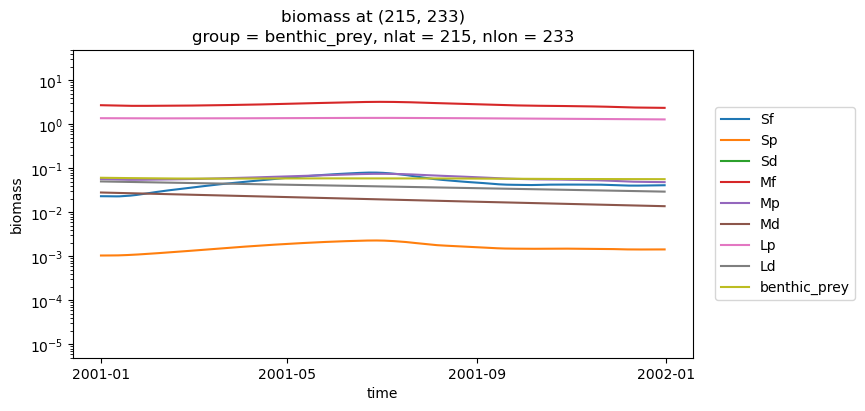

In [7]:
%%time

# Select column for time series plot
nlat = 215
nlon = 233

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for group in ds_out.group.data:
    ds_out['biomass'].isel(nlat=nlat, nlon=nlon).sel(group=group).plot()
ax.set_ylim([5e-6, 50])
ax.set_yscale("log")
plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
fig.suptitle(f"biomass at ({nlat}, {nlon})");

CPU times: user 118 ms, sys: 4.4 ms, total: 122 ms
Wall time: 257 ms


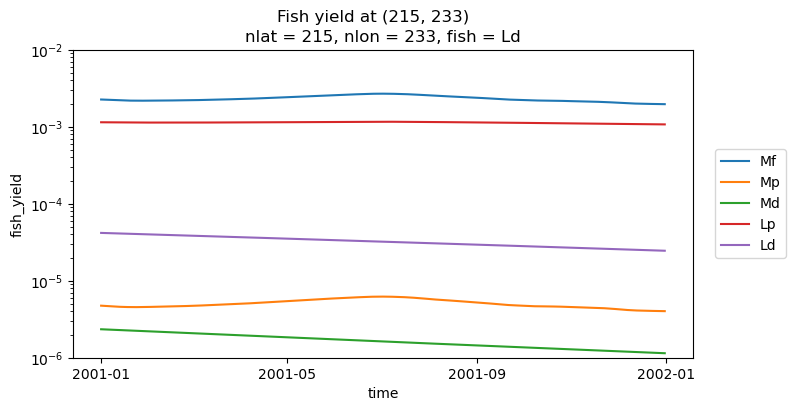

In [8]:
%%time

# Select column for time series plot
nlat = 215
nlon = 233

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plotted_fish = []
for fish in ds_out.fish.data:
    if np.nanmax(ds_out['fish_yield'].isel(nlat=nlat, nlon=nlon).sel(fish=fish).values) <= 0:
        continue
    plotted_fish.append(fish)
    ds_out['fish_yield'].isel(nlat=nlat, nlon=nlon).sel(fish=fish).plot()
ax.set_ylim([1e-6, 1e-2])
ax.set_yscale("log")
plt.legend(plotted_fish, bbox_to_anchor=(1.025, 0.5), loc=6)
fig.suptitle(f"Fish yield at ({nlat}, {nlon})");

CPU times: user 57.4 ms, sys: 364 μs, total: 57.7 ms
Wall time: 108 ms


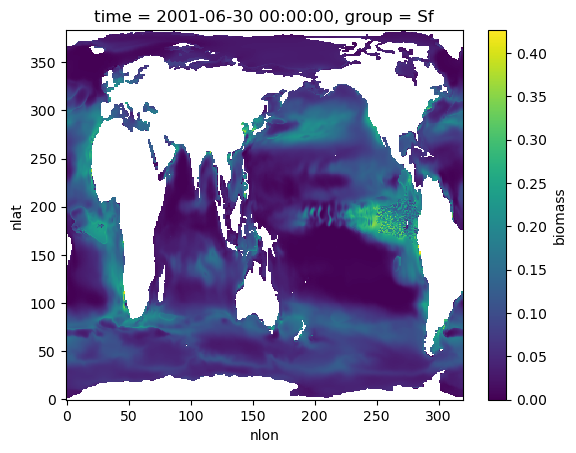

In [10]:
%%time

ds_out["biomass"].isel(time=180, group=0).plot()